In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from io import BytesIO
from IPython.display import display, Image
from PIL import Image as PILImage
import requests
import json
import pandas as pd

In [3]:
PROJECT_SUBDIR = r'/Develop/TrailSight'
COLAB_PATH = '/content/drive/MyDrive'
BASE_PATH = COLAB_PATH
PROJECT_DIR = BASE_PATH + PROJECT_SUBDIR
MODEL_PATH = PROJECT_DIR + 'model_weights.pth'

In [4]:
def load_metadata(metadata_path: str):
  with open(metadata_path, 'r') as f:
      metadata = json.load(f)
  return metadata

In [5]:
metadata = load_metadata(f"{PROJECT_DIR}/idaho-camera-traps.json")
categoeries = pd.DataFrame(metadata['categories'])
annotations = pd.DataFrame(metadata['annotations'])
images = pd.DataFrame(metadata['images'])
images_annotations = pd.merge(annotations, images, left_on='image_id', right_on='id', how='inner', suffixes=('_annotation', '_img'))
images_annotations = images_annotations[~images_annotations['category_id'].isin([29, 1, 48, 32, 26,	34 ,54])].reset_index(drop=True)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    images_annotations,
    test_size=0.2,
    stratify=images_annotations['category_id'],
    random_state=42
)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class AnimalsDataset(Dataset):
    def __init__(self, images: pd.DataFrame, labels: pd.DataFrame):
      self.categoeries = labels # this is not y, it simply maps the class id to name
      self.images_annotations = images # x, y and other metadata
      self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
      ])

    def fetch_image(self, idx):
      path = self.images_annotations.iloc[idx]['file_name']
      gcp_url = f"https://storage.googleapis.com/public-datasets-lila/idaho-camera-traps/public/{path}"
      aws_url = f"http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/idaho-camera-traps/public/{path}"
      azure_url = f"https://lilawildlife.blob.core.windows.net/lila-wildlife/idaho-camera-traps/public/{path}"
      urls = [gcp_url, aws_url, azure_url]

      for url in urls:
        try:
          response = requests.get(url, timeout=5)
          if response.status_code == 200:
            img_data = response.content
            return self.transform(PILImage.open(BytesIO(img_data))), self.images_annotations.iloc[idx]['category_id']
        except Exception as e:
          continue

      return self.create_placeholder_image(path)

    def create_placeholder_image(self, path):
      print(f"WARNING Image not found. {path}. Defaulting to empty image.")
      return torch.load("/content/drive/MyDrive/Develop/mean_image_tensor.pt"), np.int64(0)

    def __len__(self):
      return len(self.images_annotations)

    def __getitem__(self, idx):
      return self.fetch_image(idx)

    def idx_to_class(self, idx):
      if idx > len(self.categoeries):
        raise Exception("Index out of range")
      return self.categoeries.loc[idx, 'name']

In [7]:
train_data = AnimalsDataset(train_df, categoeries)

In [8]:
from collections import Counter
labels = train_data.images_annotations['category_id'].tolist()
class_counts = Counter(labels)

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]

from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_data,
    batch_size=10,
    sampler=sampler
)

In [10]:
import torch.nn as nn

class ResNetEmbedder(nn.Module):
    def __init__(self, resnet):
        super().__init__()
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

In [11]:
device = torch.device("cuda")

In [12]:
import torchvision.models as models

device = torch.device("cuda")
num_classes = train_data.categoeries['id'].nunique()
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load(MODEL_PATH))


model = ResNetEmbedder(resnet)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


ResNetEmbedder(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [200]:
import numpy as np

model.eval()
embeddings = []
labels = []
i = 0
with torch.no_grad():
    for imgs, lbls in train_loader:
        imgs = imgs.to(device)
        z = model.forward(imgs)
        embeddings.append(z.cpu().numpy())
        labels.append(lbls)
        if i > 10:
          break
        print(f"{i}/{10}")
        i+=1

embeddings = np.concatenate(embeddings, axis=0)
labels = np.array(labels)

0/10
WARNING Image not found. loc_0171/loc_0171_im_000139.jpg. Defaulting to empty image.
1/10
2/10
WARNING Image not found. loc_0185/loc_0185_im_000120.jpg. Defaulting to empty image.
3/10
4/10
5/10
WARNING Image not found. loc_0265/loc_0265_im_004202.jpg. Defaulting to empty image.
6/10
7/10
8/10
9/10
10/10


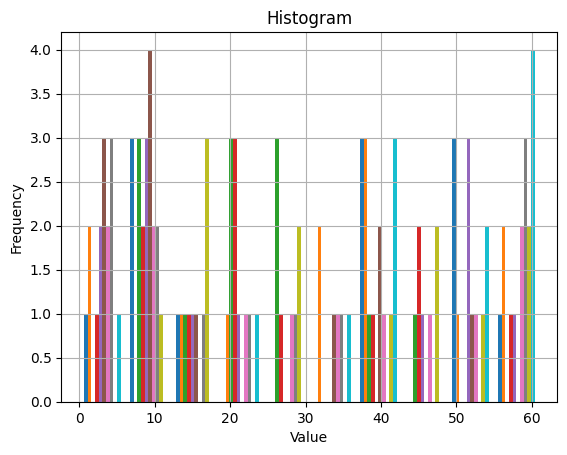

In [201]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(labels)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

<ipython-input-203-147de452414a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('tab20b', 50)


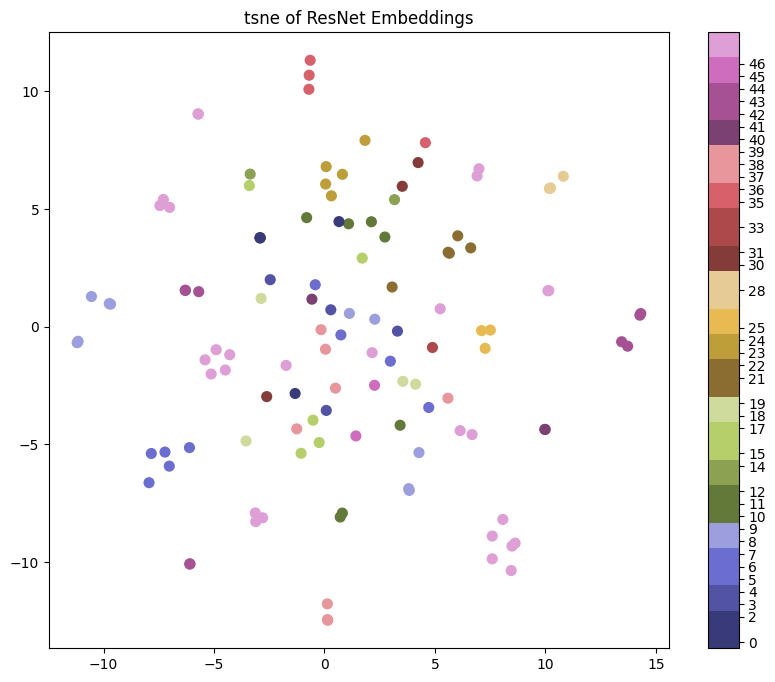

In [203]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

base_cmap = cm.get_cmap('tab20b', 50)
colors = base_cmap(range(len(np.unique(labels))))
custom_cmap = ListedColormap(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap=custom_cmap,s=len(np.unique(labels)))
plt.colorbar(scatter, ticks=np.unique(labels))
plt.clim(-0.5, len(np.unique(labels)) - 0.5)
plt.title("tsne of ResNet Embeddings")
plt.show()

In [ ]:
[print(train_data.idx_to_class(i), i) for i in range(62)]

empty 0
human 1
snow on lens 2
coyote 3
unknown 4
fox 5
mountain lion 6
other 7
bird 8
elk 9
deer 10
foggy lens 11
unknown canid 12
domestic dog 13
foggy weather 14
unknown bird of prey 15
bear 16
lagomorph 17
bobcat 18
grouse 19
pronghorn 20
malfunction 21
bighorn sheep 22
misdirected 23
unknown ungulate 24
squirrel 25
rodent 26
magpie 27
hawk 28
vehicle 29
lens obscured 30
sun 31
tilted 32
skunk 33
long-tailed weasel 34
turkey 35
bluebird 36
owl 37
wolf 38
moose 39
cattle 40
raccoon 41
vegetation obstruction 42
badger 43
varied thrush 44
unknown cervid 45
hummingbird 46
rabbit 47
horse 48
bat 49
raven 50
red-breasted nuthatch 51
western tanager 52
warbler 53
moth 54
fisher 55
crow 56
woodpecker 57
unknown cat 58
porcupine 59
ermine 60
clark's nutcracker 61


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [13]:
import torch
import torch.nn as nn

class RGB_Autoencoder(nn.Module):
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # (32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # (64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # (128, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, embedding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128 * 28 * 28),
            nn.ReLU(),
            nn.Unflatten(1, (128, 28, 28)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def get_embedding(self, x):
        return self.encoder(x)

In [14]:
model = RGB_Autoencoder(256)
model.load_state_dict(torch.load(PROJECT_DIR + 'VAE_weights.pth'))
model.to(device)

RGB_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=100352, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=100352, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 28, 28))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Sigmoid()
  )
)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(10):
    model.train()
    i = 0
    for imgs, _ in train_loader:
        output = model(imgs.to(device))
        loss = criterion(output, imgs.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"\tBatch {i} Loss: {loss.item():.4f}")
        if i % 20 == 0:
          torch.save(model.state_dict(), PROJECT_DIR + 'VAE_weights.pth')
        i += 1

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

	Batch 0 Loss: 0.5566
	Batch 1 Loss: 0.5424
WARNING Image not found. loc_0171/loc_0171_im_000138.jpg. Defaulting to empty image.
	Batch 2 Loss: 0.5956
	Batch 3 Loss: 0.5336
	Batch 4 Loss: 0.5583
	Batch 5 Loss: 0.5378
	Batch 6 Loss: 0.5622
	Batch 7 Loss: 0.4897
	Batch 8 Loss: 0.4498
WARNING Image not found. loc_0049/loc_0049_im_014262.jpg. Defaulting to empty image.
	Batch 9 Loss: 0.5202
	Batch 10 Loss: 0.4884
	Batch 11 Loss: 0.4848
	Batch 12 Loss: 0.5434
	Batch 13 Loss: 0.5143
	Batch 14 Loss: 0.4807
	Batch 15 Loss: 0.5340
	Batch 16 Loss: 0.5698
	Batch 17 Loss: 0.5105
WARNING Image not found. loc_0171/loc_0171_im_000143.jpg. Defaulting to empty image.
	Batch 18 Loss: 0.5488
	Batch 19 Loss: 0.5663
	Batch 20 Loss: 0.5471
	Batch 21 Loss: 0.5619
	Batch 22 Loss: 0.5333
	Batch 23 Loss: 0.5191
WARNING Image not found. loc_0171/loc_0171_im_000114.jpg. Defaulting to empty image.
	Batch 24 Loss: 0.5216
	Batch 25 Loss: 0.5237
WARNING Image not found. loc_0016/loc_0016_im_010558.jpg. Defaulting to 

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), PROJECT_DIR + 'VAE_weights.pth')

In [20]:
model.to(device)
embeddings = []
labels = []
i = 0
with torch.no_grad():
    for imgs, lbls in train_loader:
        imgs = imgs.to(device)
        z = model.get_embedding(imgs)
        embeddings.append(z.view(10, -1).cpu().numpy())
        labels.append(lbls)
        if i > 10:
          break
        print(f"{i}/{10}")
        i+=1

0/10
1/10
WARNING Image not found. loc_0016/loc_0016_im_010546.jpg. Defaulting to empty image.
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


In [17]:
embeddings = np.concatenate(embeddings, axis=0)
labels = np.array(labels)

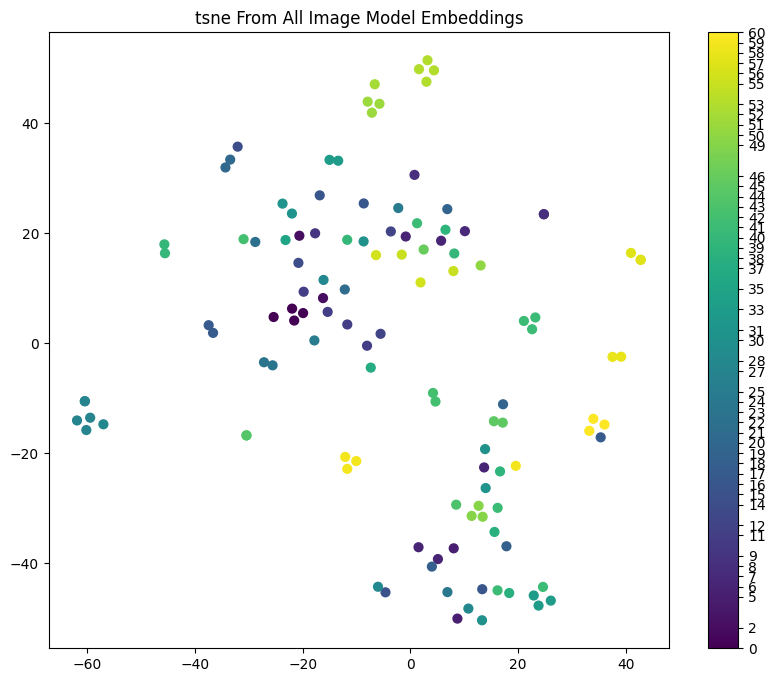

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, s=40)
plt.colorbar(scatter, ticks=np.unique(labels))
plt.title("tsne From All Image Model Embeddings")
plt.show()

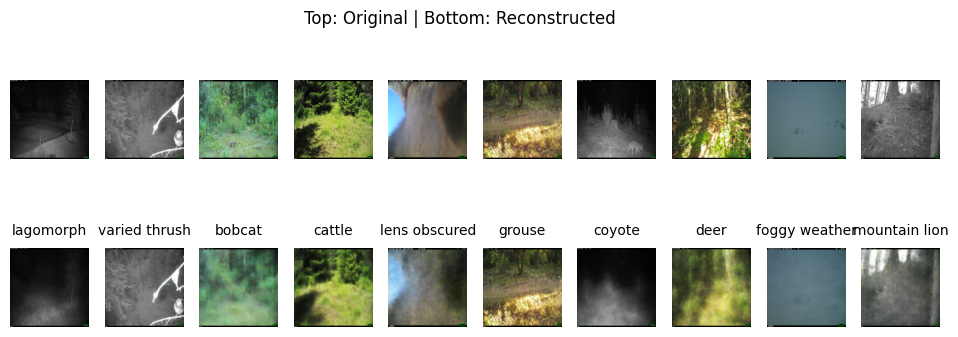

In [ ]:
import matplotlib.pyplot as plt
model.to(device)
with torch.no_grad():
    imgs, _ = next(iter(train_loader))
    imgs = imgs.to(device)
    recon = model(imgs)



n = len(imgs)
plt.figure(figsize=(12, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(recon[i].permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    ax.set_title(str(train_data.idx_to_class(int(_[i]))), fontsize=10, pad=10)
plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()



In [ ]:
empty_ae = RGB_Autoencoder(256)
empty_ae.to(device)

RGB_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=100352, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=100352, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 28, 28))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
empties = images_annotations[images_annotations['category_id'].isin([0])].reset_index(drop=True)
empties.reset_index(drop=True, inplace=True)
empty = AnimalsDataset(empties, categoeries)
empty_loader = DataLoader(
    empty,
    batch_size=10,
    shuffle=True
)

In [ ]:
optimizer = torch.optim.Adam(empty_ae.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(10):
    empty_ae.train()
    i = 0
    for imgs, _ in empty_loader:
        output = empty_ae(imgs.to(device))
        loss = criterion(output, imgs.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"\tBatch {i} Loss: {loss.item():.4f}")
        if i % 20 == 0:
          torch.save(empty_ae.state_dict(), PROJECT_DIR + 'empty_AE_weights.pth')
        i += 1

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

	Batch 0 Loss: 0.6343
	Batch 1 Loss: 0.6268
	Batch 2 Loss: 0.6404
	Batch 3 Loss: 0.6478
	Batch 4 Loss: 0.6428
	Batch 5 Loss: 0.6420
	Batch 6 Loss: 0.6564
	Batch 7 Loss: 0.6385
	Batch 8 Loss: 0.6602
	Batch 9 Loss: 0.6209
	Batch 10 Loss: 0.6382
	Batch 11 Loss: 0.6098
	Batch 12 Loss: 0.6511
	Batch 13 Loss: 0.5779
	Batch 14 Loss: 0.5851
	Batch 15 Loss: 0.6467
	Batch 16 Loss: 0.6483
	Batch 17 Loss: 0.6529
	Batch 18 Loss: 0.6377
	Batch 19 Loss: 0.6474
	Batch 20 Loss: 0.6544
	Batch 21 Loss: 0.6422
	Batch 22 Loss: 0.6503
	Batch 23 Loss: 0.6541
	Batch 24 Loss: 0.5981
	Batch 25 Loss: 0.6480
	Batch 26 Loss: 0.6053
	Batch 27 Loss: 0.6114
	Batch 28 Loss: 0.6242
	Batch 29 Loss: 0.6290
	Batch 30 Loss: 0.6125
	Batch 31 Loss: 0.6200
	Batch 32 Loss: 0.6510
	Batch 33 Loss: 0.6409
	Batch 34 Loss: 0.6319
	Batch 35 Loss: 0.6183
	Batch 36 Loss: 0.6559
	Batch 37 Loss: 0.6343
	Batch 38 Loss: 0.6450
	Batch 39 Loss: 0.6329
	Batch 40 Loss: 0.5994
	Batch 41 Loss: 0.6097
	Batch 42 Loss: 0.6357
	Batch 43 Loss: 0.579

KeyboardInterrupt: 

tensor(0.5864, device='cuda:0')


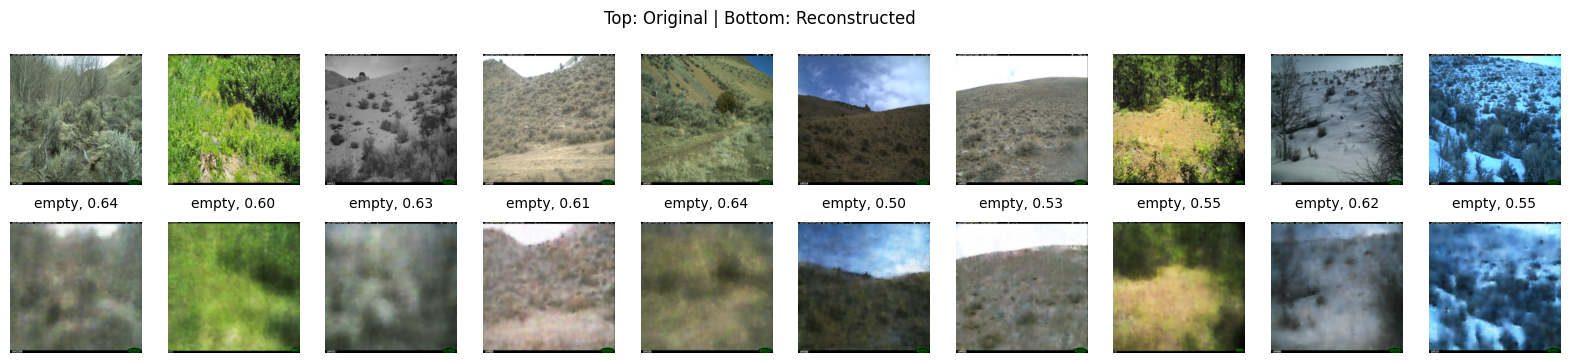

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.BCELoss(reduction='none')

model.to(device)
with torch.no_grad():
    imgs, labels = next(iter(empty_loader))
    imgs = imgs.to(device)
    recon = model(imgs)
    loss = criterion(recon, imgs)
    loss_per_sample = loss.view(loss.size(0), -1).mean(dim=1)

print(loss_per_sample.mean())

n = len(imgs)
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(recon[i].permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    ax.set_title(f"{train_data.idx_to_class(int(labels[i]))}, {loss_per_sample[i]:.2f}", fontsize=10, pad=10)
plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()

In [ ]:
non_empties = images_annotations[~images_annotations['category_id'].isin([0])].reset_index(drop=True)
non_empties.reset_index(drop=True, inplace=True)
not_empty = AnimalsDataset(non_empties, categoeries)


labels = non_empties['category_id'].tolist()
class_counts = Counter(labels)

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]

from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

not_empty_loader = DataLoader(
    not_empty,
    batch_size=10,
    sampler=sampler
)

tensor(0.5394, device='cuda:0')


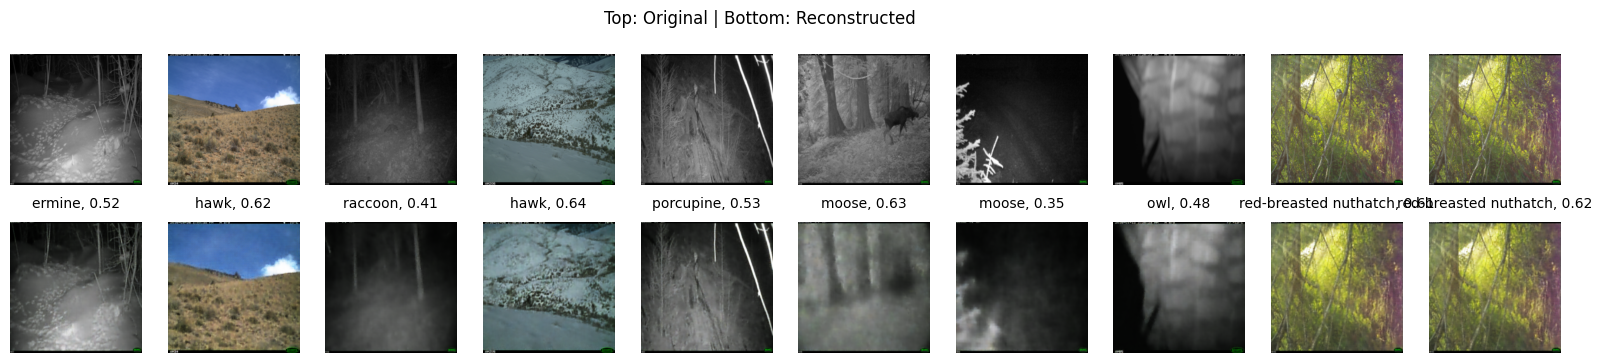

In [ ]:
model.to(device)

criterion = nn.BCELoss(reduction='none')

with torch.no_grad():
    imgs, labels = next(iter(not_empty_loader))
    imgs = imgs.to(device)
    recon_animals = model(imgs)
    loss = criterion(recon_animals, imgs)
    loss_per_sample = loss.view(loss.size(0), -1).mean(dim=1)

print(loss_per_sample.mean())

n = len(imgs)
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(recon_animals[i].permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    ax.set_title(f"{train_data.idx_to_class(int(labels[i]))}, {loss_per_sample[i]:.2f}", fontsize=10, pad=10)
plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()

In [ ]:
combined = torch.cat([recon.view(10, -1), recon_animals.view(10, -1)], dim=0)
combined = combined.cpu().numpy()
labels = [0] * recon.shape[0] + [1] * recon_animals.shape[0]

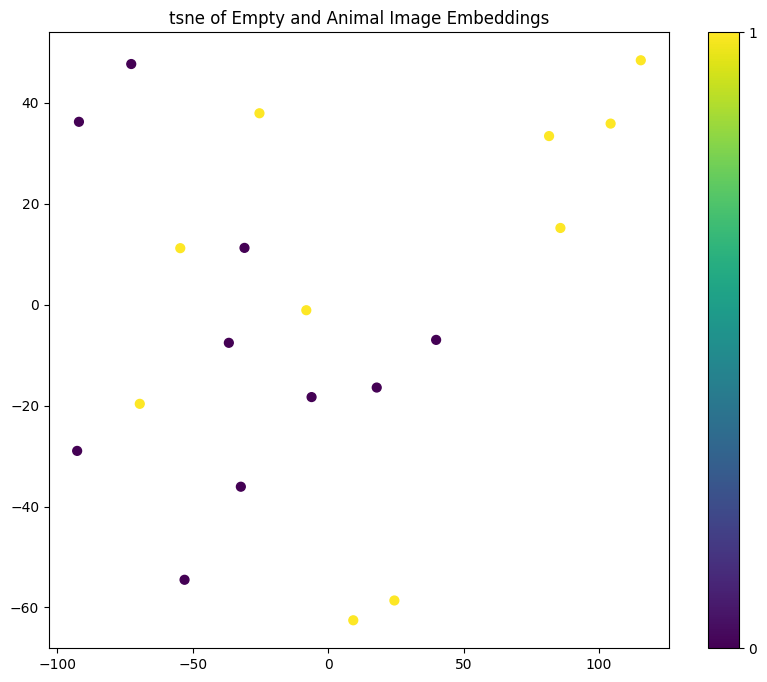

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(combined)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, s=40)
plt.colorbar(scatter, ticks=np.unique(labels))
plt.title("tsne of Empty and Animal Image Embeddings")
plt.show()